## Results of point pollution surface oil spill scenario at Turn Point
Dilbit Tanker fails to make the turn in outbound shipping lane at Turn Point and hits Arachne Reef, spilling 2000 m<sup>-3</sup> of Dilbit.

In [1]:
import os
import xarray as xr
import numpy as np
import itertools
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Define scenario and control files

In [2]:
hex_colour = '#6DB48E'
hatches = ['oo', '///', 'xx', '++']

In [3]:
# Oil injection file 
oil_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/')
oil_paths = sorted([p for p in oil_root.glob('SSAM_Scenario_5b*_10000_alkyls.nc')])
oil_files = [xr.open_dataset(oil_scen,decode_cf=True) for oil_scen in oil_paths]

In [4]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Control/highres-control-3y-2019-2022/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])


In [5]:
scenario_paths = sorted([p for p in scenario_root.glob('highres-2019-2022_5b*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

highres-2019-2022_5b_1_2019-01-20 low Fraser flow spring tide winter
highres-2019-2022_5b_2_2019-01-14 low Fraser flow neap tide winter
highres-2019-2022_5b_3_2020-01-24 high Fraser flow spring tide winter
highres-2019-2022_5b_4_2020-01-16 high Fraser flow neap tide winter


In [6]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [7]:
# time after burn-in
start = 0
end = time.size-1

In [8]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Mapping spill extent

TP-2 BOX_ID
1     655575973
2     682702420
5     261808665
8     485601055
9     288060859
33    181216243
60    322474724
Name: AREA, dtype: int64
TP-1 BOX_ID
1     655575973
2     682702420
3     494069246
4     446328916
5     261808665
8     485601055
9     288060859
33    181216243
34    116214640
37     61024272
60    322474724
Name: AREA, dtype: int64
TP-4 BOX_ID
1     655575973
5     261808665
33    181216243
34    116214640
60    322474724
66    130534737
Name: AREA, dtype: int64
TP-3 BOX_ID
5     261808665
8     485601055
9     288060859
33    181216243
60    322474724
Name: AREA, dtype: int64


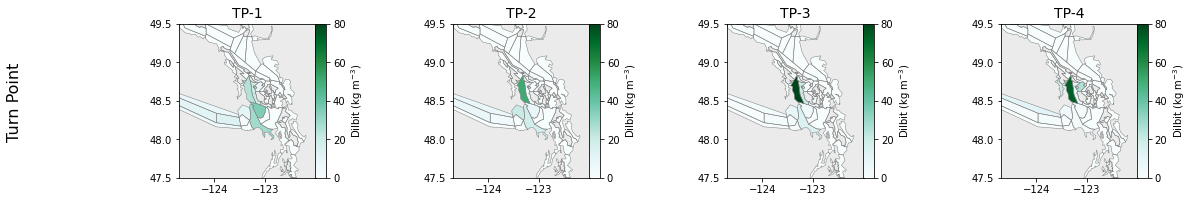

In [9]:
fig = plt.figure(figsize=(18, 6), facecolor='white') #figsize=(9, 12)
gs = plt.GridSpec(1, len(oil_files), wspace=0.5, hspace=0.2, height_ratios=[1],)

for file, oil_path in zip(oil_files, oil_paths):
    date = str(oil_path).split(sep = '_')[3]
    label = 'TP-'+ str(groups.simulations[groups.conditions[date]])
    position = int(str(groups.simulations[groups.conditions[date]]))-1
    oil_tb = file.variables['oil']
    oil_b = oil_tb.mean(axis=0)

    # Add scenario data to Atlantis spatial data
    data_df['oil'] = oil_b
    data_df.loc[land_boxes, 'oil'] = 0
    oil_df = data_df.loc[data_df['oil'] > 4] 
    print(label,oil_df.AREA)

    ax = fig.add_subplot(gs[0, position], facecolor = '#EBEBEB')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.5)
    ax = data_df.plot(column = 'oil', ax=ax, cax=cax,cmap=cm.BuGn, legend_kwds={'label': 'Dilbit (kg m$^{-3}$)'}, vmax=80,
    #ax = data_df.plot(column = 'BOTZ', ax=ax, cax=cax,cmap=cm.Blues, legend_kwds={'label': 'depth (m)'},
    legend=True, 
    )
    ax.set_title(label, fontsize = 14)
    ax.set_xlim(-124.7)
    ax.set_ylim(47.5, 49.5)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.5)
    land_df.plot(ax=ax, color='#EBEBEB')
    #oil_df.plot(ax=ax, color='red',linewidths=0.5)
fig.supylabel('Turn Point', fontsize = 16); #color=hex_colour
fig.savefig("Figures/spill-map-TP.png", dpi=300, bbox_inches='tight')

In [10]:
affected_boxes = [1, 2, 3, 4, 5, 8, 9, 33, 34, 37, 60, 66]

#### Concentration of PAH in seawater

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

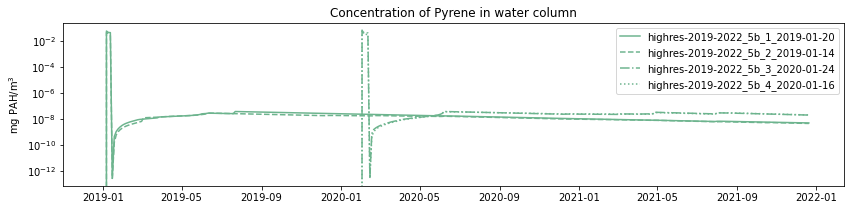

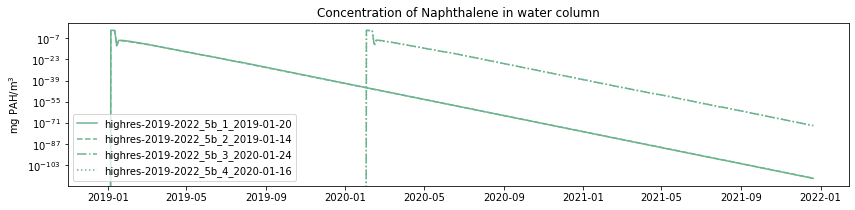

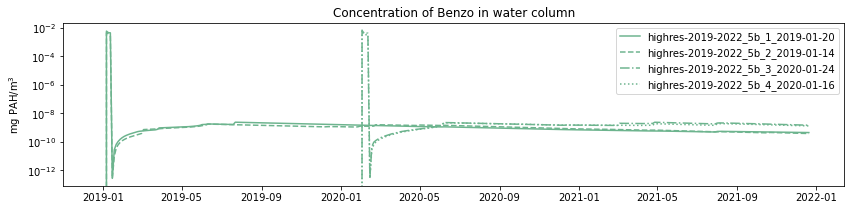

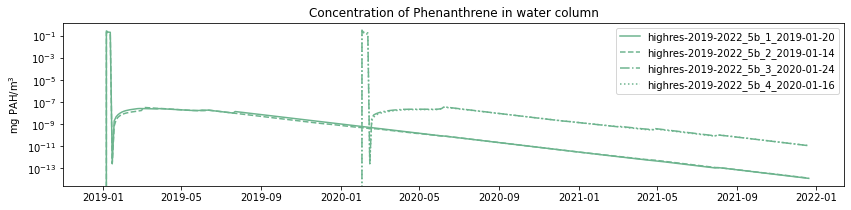

In [11]:
for pah in groups.pahs:
  fig, ax = plt.subplots(figsize = (14,3))
  names = []
  line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
  for scenario, path, i in zip(scenario_datasets,scenario_paths,range(0,len(scenario_datasets))):
      nm = path.parent.stem
      names.append(nm)
      contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
      contam_tb = contam_tbl.sum(axis=2)
      contam_t = contam_tb.sum(axis=1)
      ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
  ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
  ax.set_ylabel('mg PAH/m$^3$')
  ax.legend(names, loc='best')

## Results

In [12]:
def plot_groups_pelagic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [13]:
def plot_groups_benthic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

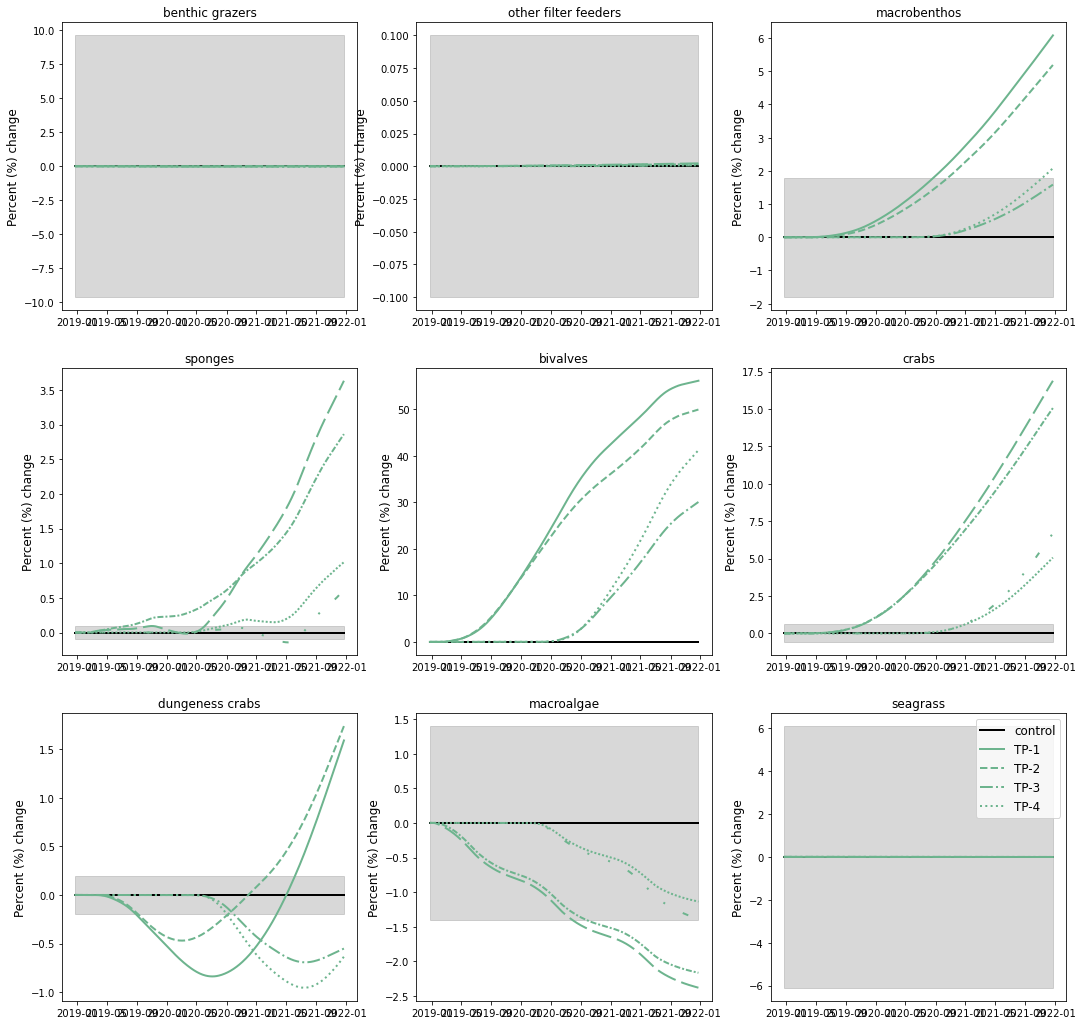

In [14]:
plot_groups_benthic_N(groups.benthos, scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

In [15]:
def plot_benthic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k')
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

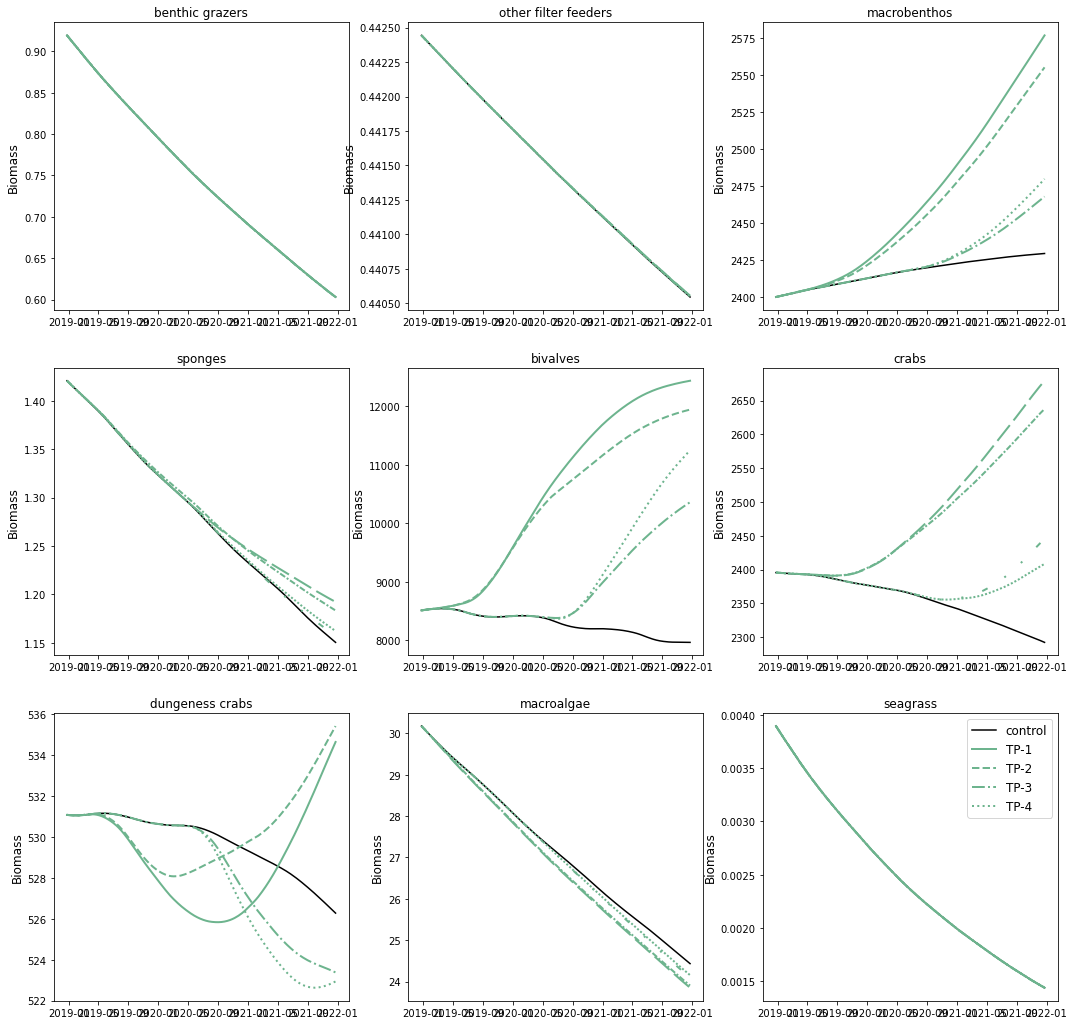

In [16]:
plot_benthic_biomass(groups.benthos, scenario_datasets, scenario_paths, boxes=affected_boxes)

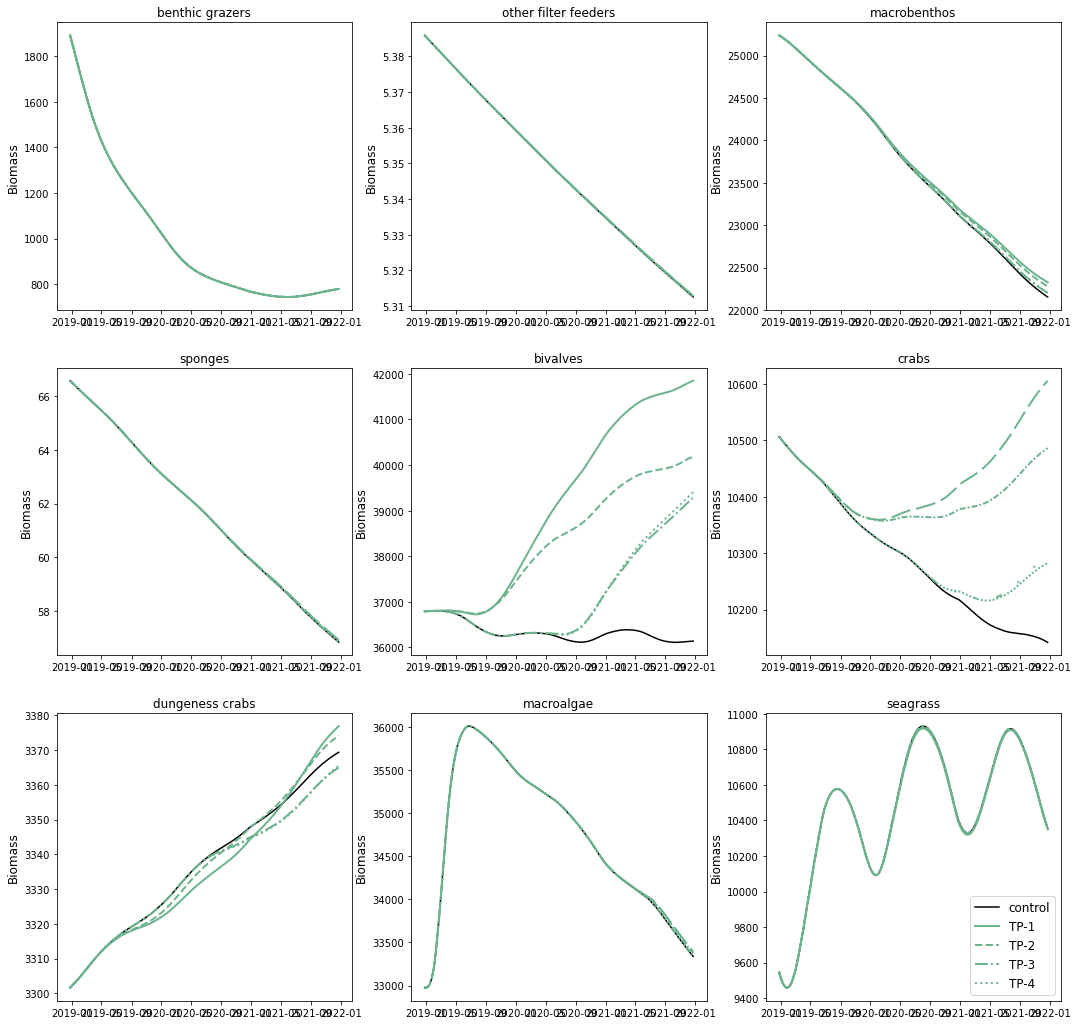

In [17]:
plot_benthic_biomass(groups.benthos, scenario_datasets, scenario_paths)